# Transmission matrix reconstruction


This notebook explains how to compute a transmission matrix $A\in\mathbb{C}^{m\times n}$ for model $$|Ax| = b,$$ where the set of couples $D=\big\{\big(x^{(i)}, b^{(i)}\big)\big\}_{i=1}^N$ is given.

Let $X=\big\{x^{(1)},\dots,x^{(N)}\big\}^\top \in\mathbb{C}^{N\times n}$ and $B = \big\{b^{(1)},\dots,b^{(N)}\big\}^\top \in\mathbb{R}^{N\times m}_+$.

The idea is to recover each row $a_j\in\mathbb{C}^n$ for $j\in\{1,\dots,m\}$ of matrix $A$ separately solving $m$ optimization problems
\begin{equation}
    a_j = \text{argmin}_{a\in\mathbb{C}^n} \||Xa| - b_{\cdot j}\|, \; \text{for} j\in\{1,\dots,m\},
\end{equation}
where $b_{\cdot j}\in\mathbb{R}^{N}_+$ is the $j$-th **column** of the matrix $B$.

In [2]:
import phrt_opt

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from scipy.io import loadmat


plt.rcParams.update({'font.size': 12})

np.random.seed(42)


def randn_like(arr):
    size = np.shape(arr)
    res = np.random.normal(size=size)
    if np.iscomplexobj(arr):
        res = res + 1j * np.random.normal(size=size)
    return res

## 1. Experimental data loading

The dataset contains $N=1000$ examples of vectors of phases $x\in\mathbb{C}^n$ and their measured intensities $b\in\mathbb{R}_+^m$, where $n = 16$ and $m = 64$.

In [3]:
mat = loadmat("./data/SGMG.mat")
X, B = mat["SG"], mat["MG"]

N, n = X.shape
_, m = B.shape

print("Dataset for reconstruction:")
print(f" - X: shape = {X.shape}, dtype = {X.dtype}")
print(f" - B: shape = {B.shape}, dtype = {B.dtype}")

FileNotFoundError: [Errno 2] No such file or directory: './data/SGMG.mat'

In [4]:
import os
import mat73
path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_90deg.mat"
data = mat73.loadmat(os.path.join(path, file))

CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

In [26]:
import fibernet
from utils.utils import get_subsets, select_pixels, crop_img

NN = CP.shape[0]
As = np.zeros(shape=(NN, 32), dtype=complex)
Bs = np.zeros(shape=(NN, 122*122), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

idxs = np.arange(25, 103, 128/30).astype(int)
print(idxs.shape)
Bs = np.zeros(shape=(NN, len(idxs)**2), dtype=float)

for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    phi = np.exp(1j * phi)
    phi = np.delete(vec[i], [0, 5, 30, 35])
    img = crop_img(CP[i], crop=3)
    img = select_pixels(img, idxs)
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img)

(19,)


In [28]:
X, B = get_subsets(As, Bs, N=200, randomize=False)

N, n = X.shape
_, m = B.shape

print("Dataset for reconstruction:")
print(f" - X: shape = {X.shape}, dtype = {X.dtype}")
print(f" - B: shape = {B.shape}, dtype = {B.dtype}")

Dataset for reconstruction:
 - X: shape = (200, 32), dtype = complex128
 - B: shape = (200, 361), dtype = float64


## 2. Matrix rows initialization

Each numerical optimization problem requires an initial point to start iterations. 

There are several techniques to find a good initial point for a phase retrieval problem such as 
- [Wirtinger Flow (Algorithm 1)](https://viterbi-web.usc.edu/~soltanol/WFalg.html), that is implemented in  `phrt_opt.initializers.Wirtinger`.
- [Gao & Xu initialization (Algorithm 1)](https://arxiv.org/abs/1606.08135), that is implemented in `phrt_opt.initializers.GaoXu`.

All of them are spectral methods, which means that they compute the eigenvector with the largest magnitude of a special matrix. This computation can be done by means of the iterative algorithm which is called [Power method](https://en.wikipedia.org/wiki/Power_iteration).

Thus, all initializationi algorithms takes as an argument the Power method with defined stopping tolerance `phrt_opt.eig.PowerMethod(tol=1e-3)` for example.

Let us initialize each row of matrix $A$ using Gao & Xu initializer, which gives better initialization than Wirtinger Flow algorithm.

In [29]:
power_method = phrt_opt.eig.PowerMethod(tol=1e-1)
initializer = phrt_opt.initializers.GaoXu(power_method)

A0 = np.concatenate([
    initializer(X, B[:, [i]]) for i in tqdm(range(m), unit='row', desc="Matrix initialization")
], axis=-1)

Matrix initialization: 100%|██████████| 361/361 [00:01<00:00, 354.73row/s]


## 3. Solving $m$ optimization problems

In this section, we need to solve $m$ optimization problems to recover $m$ rows of the matrix $A$ separately.

The main question is "How to evaluate the quality of recovered rows?". The optimization algorithms stop iterations when the distance between the previous and current solutions approximation is smaller than a selected tolerance `tol`. However, this stopping test gives no guarantee that the found solution is a global one (i.e. not a local extremum).

**That is why, it is proposed to check if the recovered row is good enough in comparison with other retrieved rows.**

Let us show the proposed approach directly on the following example.

### Example:

Let us initialize matrix $A$ with random vectors instead of using spectral methods. This is just to show how to detect poorly retrieved rows.

In [30]:
initializer = phrt_opt.initializers.Random(random_state=np.random.RandomState(42))

A0 = np.concatenate([
    initializer(X, B[:, [i]]) for i in tqdm(range(m), unit='row', desc="Matrix initialization")
], axis=-1)

Matrix initialization: 100%|██████████| 361/361 [00:00<00:00, 121083.07row/s]


Let us compute the pseudo-inverse of $X$ once to use it further in oprimization loops.

In [31]:
X_pinv = np.linalg.pinv(X)

Let us apply the Alternating projections method to retrieve all rows.

In [32]:
Ak = np.concatenate([
    phrt_opt.methods.alternating_projections(
        tm=X, 
        b=B[:, [i]], 
        x0=A0[:, [i]], 
        tm_pinv=X_pinv, 
    )
    for i in tqdm(range(m), unit='row', desc="Matrix reconstruction")
], axis=-1)

Matrix reconstruction: 100%|██████████| 361/361 [00:13<00:00, 25.95row/s]


Let us compute relative errors for each row.

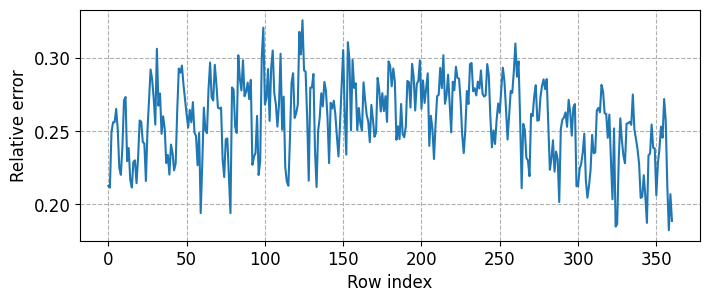

In [33]:
r_err = norm(np.abs(X @ Ak) - B, axis=0) / norm(B, axis=0)

plt.figure(figsize=(8, 3))
plt.plot(r_err)
plt.grid(True, linestyle='--')
plt.xlabel("Row index")
plt.ylabel("Relative error")
plt.show()

One can see that there are pics, that probably indicate poorly retrieved rows. To find a threshold to detect these pics we assume that errors are normaly distribured. If so, than we can detect the outliers in the data. For that we compute a [standard score](https://en.wikipedia.org/wiki/Standard_score) (or z-score) which is the number of standard deviations by which the observed value is above or below the mean value of what is being observed or measured.

This score $z$ has the following connection with the probability $P(\xi < z) = p$ that a random variable $\xi\sim\mathcal{N}(0, 1)$ will be less that given value $z$. So it is possible to compute $z$ with given $p$ using cumulative distribution function CDF

In [34]:
z = 1.645
p = stats.norm.cdf(z)
print(f"p = {p:.3f}, z = {z:.3f}")

p = 0.950, z = 1.645


and vice versa using percent point function (PPF), which is an inverse of CDF.

In [35]:
p = 0.95
s = stats.norm.ppf(p)
print(f"p = {p:.3f}, z = {z:.3f}")

p = 0.950, z = 1.645


This example is visualized on the following figure.
![img](https://i.stack.imgur.com/fGYNp.png)

The statistic is computed for standard normal distribution (i.e. with zero mean and unit standard deviation). Thus to compute this value for our data we need to scale it by std and shift by mean.

In [36]:
z_score = np.mean(r_err) + s * np.std(r_err)
print(f"Z-score: {z_score:.3f}")

Z-score: 0.302


or to use directly scipy functionality

In [37]:
z_score = stats.norm.ppf(p, loc=np.mean(r_err), scale=np.std(r_err))
print(f"Z-score: {z_score:.3f}")

Z-score: 0.302


Let us add the z-score to the previous plot.

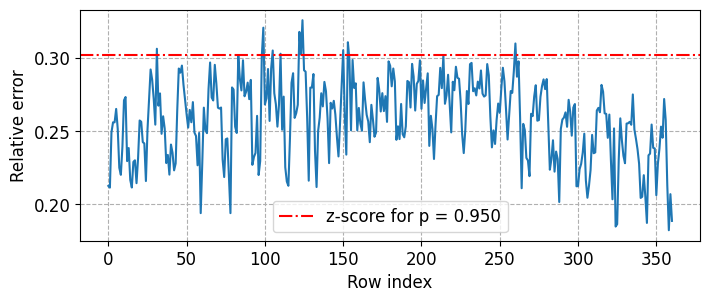

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(r_err)
plt.grid(True, linestyle='--')
plt.axhline(z_score, color='r', linestyle='-.', label=f'z-score for p = {p:.3f}')
plt.xlabel("Row index")
plt.ylabel("Relative error")
plt.legend()
plt.show()

Then we can compute outliers mask and apply it to select rows to replace.

In [39]:
mask = r_err > z_score

print(f"Number of outliers: {np.sum(mask)}")

Number of outliers: 10


Let us run again the optimization algorithm for selected rows starting with random point.

In [40]:
Ak[:, mask] = np.concatenate([
    phrt_opt.methods.alternating_projections(
        tm=X, 
        b=B[:, [i]], 
        x0=randn_like(A0[:, [i]]), 
        tm_pinv=X_pinv, 
    )
    for i in tqdm(np.nonzero(mask)[0], unit='row', desc="Matrix reconstruction")
], axis=-1)

Matrix reconstruction: 100%|██████████| 10/10 [00:00<00:00, 24.76row/s]


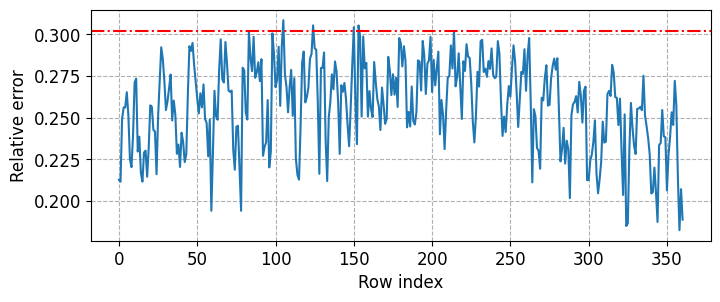

Number of outliers: 4


In [41]:
r_err = norm(np.abs(X @ Ak) - B, axis=0) / norm(B, axis=0)

plt.figure(figsize=(8, 3))
plt.plot(r_err)
plt.grid(True, linestyle='--')
plt.axhline(z_score, color='r', linestyle='-.', label=f'z-score for p = {p:.3f}')
plt.xlabel("Row index")
plt.ylabel("Relative error")
plt.show()

mask = r_err > z_score

print(f"Number of outliers: {np.sum(mask)}")

We succeed to correct 3 outliers after one attempt to improve the quality of retrieved rows. It is proposed to repeat this process until all rows are corrected of maximal number of attempts is achieved. If correction is not achieved, then the best approximation is selected.

### Implemeted method in `phrt_opt`

In [42]:
A = phrt_opt.retrieve_transmission_matrix(X, B, verbose=1)

r_err = norm(np.abs(X @ A.T) - B, axis=0) / norm(B, axis=0)
mean_rel_rec_err = np.mean(r_err)
print(f"Mean relative recovering error: {mean_rel_rec_err:.3f}")

Attempt  1: number of outliers =  0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 361 is different from 32)

## 4. Measurements unbiasing

One can easily detect the presence of a camera shift in the experimental dataset by computing the minimal measumerent value.

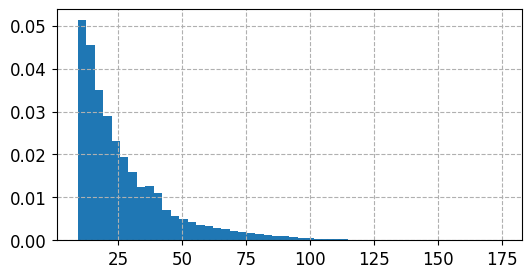

Minimal measurement value: 9.11


In [186]:
plt.figure(figsize=(6, 3))
plt.hist(B.ravel(), bins=50, density=True)
plt.grid(True, linestyle='--')
plt.show()

print(f"Minimal measurement value: {B.min():.2f}")

It is better to work with unbiased data since the original model $|Ax|=b$ has no bias. Thus we can simply unbias measurement data by subtracting its minimal value.

In [187]:
A = phrt_opt.retrieve_transmission_matrix(X, B - B.min(), verbose=1)

r_err = norm(np.abs(X @ A.T) - (B - B.min()), axis=0) / norm(B - B.min(), axis=0)
min_unb_mean_rel_rec_err = np.mean(r_err)
print(f"Unbiased mean relative recovering error: {min_unb_mean_rel_rec_err:.3f}")

Attempt  1: number of outliers =  0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 784 is different from 32)

The obtained mean relative error is smaller than computed above. However, it is not the best approach to compute a camera shift. The algorithm to do that is explained in my [thesis](https://www.theses.fr/2022LIMO0120) (Algorithm 18 in the Appendix A).

In [169]:
bias = phrt_opt.compute_camera_bias(X, B, verbose=1)

Iteration  1: camera bias = -0.0027


In [203]:
A = phrt_opt.retrieve_transmission_matrix(X, B - bias, verbose=1)

r_err = norm(np.abs(X @ A.T) - (B - bias), axis=0) / norm(B - bias, axis=0)
unb_mean_rel_rec_err = np.mean(r_err)
print(f"Unbiased mean relative recovering error: {unb_mean_rel_rec_err:.3f}")

Attempt  1: number of outliers =  0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 784 is different from 32)

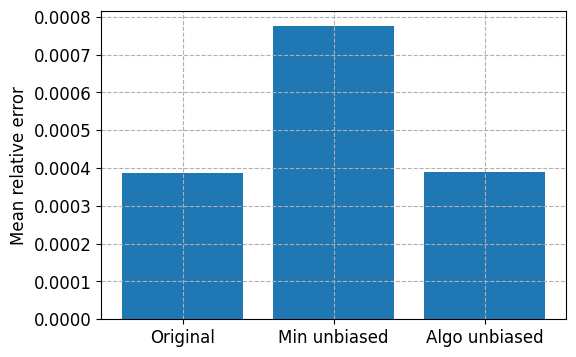

In [204]:
plt.figure(figsize=(6, 4))
plt.bar(["Original", "Min unbiased", "Algo unbiased"], 
        [mean_rel_rec_err, min_unb_mean_rel_rec_err, unb_mean_rel_rec_err])
plt.grid(True, linestyle="--")
plt.ylabel("Mean relative error")
plt.show()

In [207]:
print(A.shape)
print(X.shape)

(32, 784)
(200, 32)


MSE = 926.9604544564603


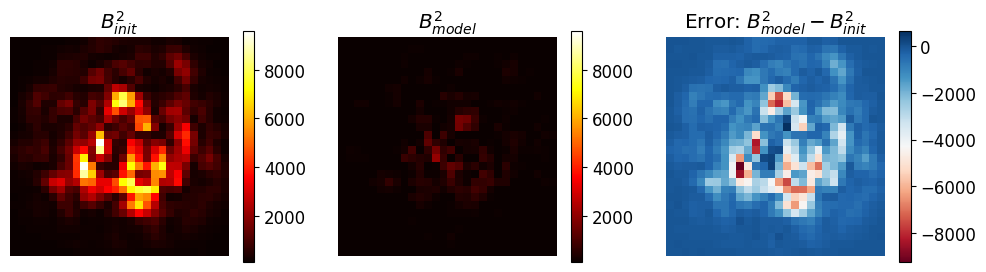

In [212]:
i = 50
A_init = X

Y_model = np.dot(A.T, X.T)
B_model = np.abs(Y_model.T)
b_init_check = np.reshape(B[i,:], (len(idxs),len(idxs)))
b_model_check = np.reshape(B_model[i,:], (len(idxs),len(idxs)))

fig, axs = plt.subplots(1,3, figsize=(12,3))
pl0 = axs[0].imshow(np.square(b_init_check ), cmap="hot")
pl1 = axs[1].imshow(np.square(b_model_check), cmap="hot", vmin=np.min(np.square(b_init_check )), vmax=np.max(np.square(b_init_check )))
pl2 = axs[2].imshow(np.square(b_model_check) - np.square(b_init_check), cmap="RdBu")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])
plt.colorbar(pl2, ax=axs[2])
axs[0].set_title(r"$B_{init}^2$")
axs[1].set_title(r"$B_{model}^2$")
axs[2].set_title(r"Error: $B_{model}^2 - B_{init}^2$")
[ axs[i].axis('off') for i in range(len(axs)) ]

print(f"MSE = {np.mean(np.abs(np.square(B_model) - np.square(B)))}")